In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import csv
from statsmodels.tsa.stattools import pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
month = '201305'

towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1003 and 1008 J/kg.K, thus we can assume it constant at 1005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

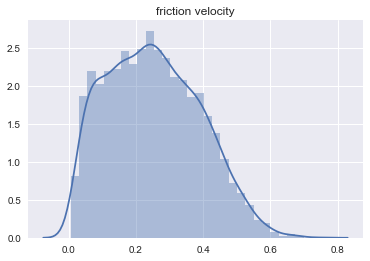

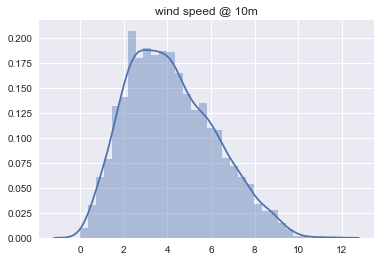

In [3]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

sns.distplot(towmetds['F'][:, -2])
plt.title('wind speed @ 10m')
plt.show()

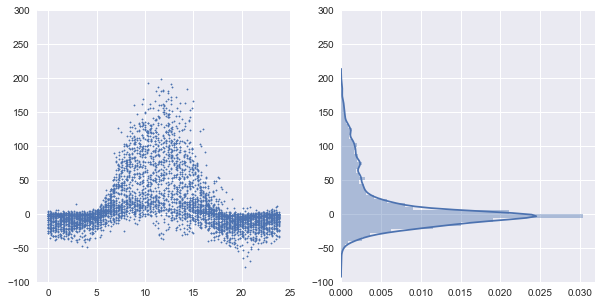

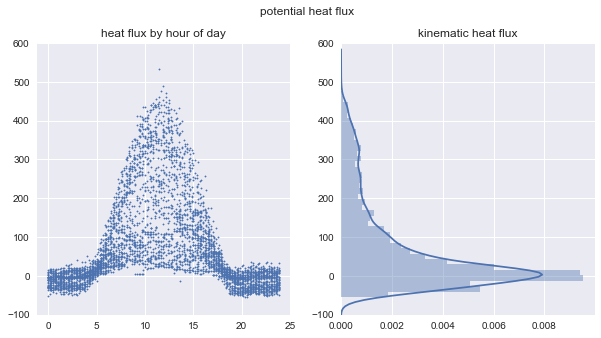

In [4]:
plt.figure(figsize=(10, 5))
plt.title('kinematic heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['H'][:], s=2)
plt.ylim(-100, 300)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['H'][:], vertical=True)
plt.ylim(-100, 300)
plt.show()

plt.figure(figsize=(10, 5))
plt.suptitle('potential heat flux')
plt.subplot(1, 2, 1)
plt.title('heat flux by hour of day')
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.title('kinematic heat flux')
plt.ylim(-100, 600)
plt.show()

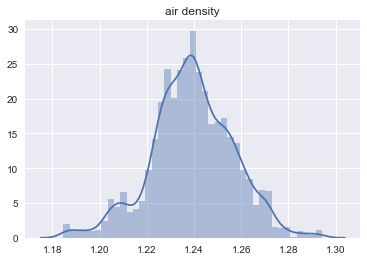

In [5]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

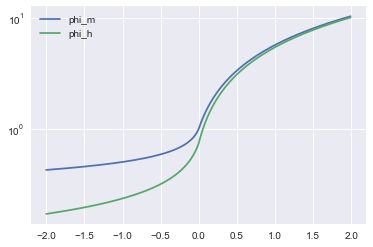

In [6]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

## computing profiles

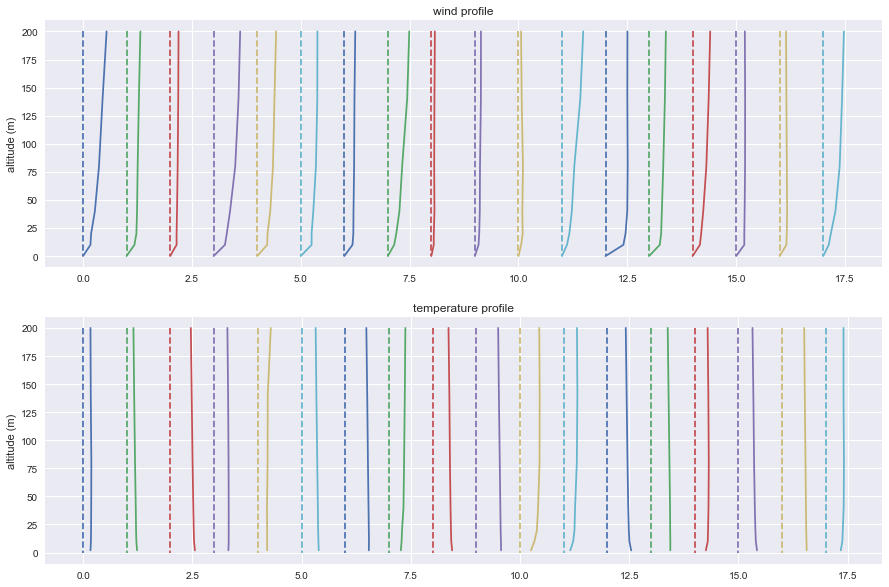

In [7]:
plt.figure(figsize=(15, 5))


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

for i, tt in enumerate(towmetds['time'][::250]):
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 20 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 30 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

### polynomial/spline interpolation

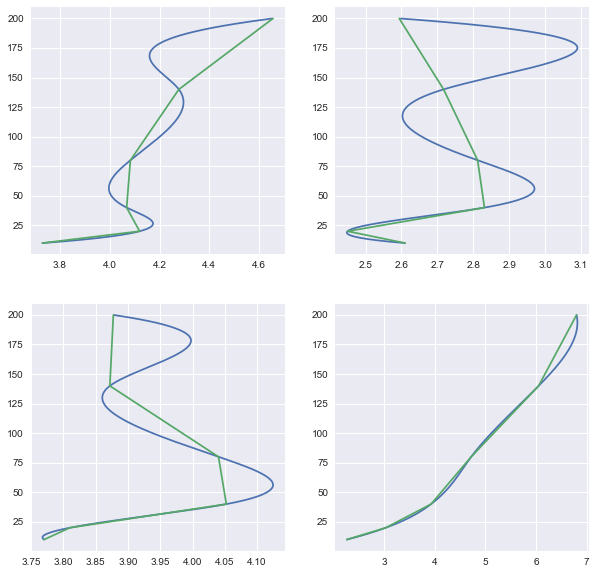

In [8]:
from scipy.interpolate import spline

plt.figure(figsize=(10, 10))
for i, tt in enumerate([44, 351, 631, 551]):
    zi = np.arange(10, 200, 0.1)
    wi = spline(towmetds['z'][:6][::-1], towmetds['F'][tt][:-1][::-1], zi, order=3)

    plt.subplot(2, 2, i + 1)
    plt.plot(wi, zi)
    plt.plot(towmetds['F'][tt][:-1], towmetds['z'][:6])

plt.show()

not a good option: the curves are too wiggly. the problem is that the spline passes exactly through all points, and does not allow noise

### non-parametric regression

for wind, we can try gaussian processes with the kernel

$$
k(z_1,z_2)
=\exp\left(-\frac{(z_1-z_2)^2}{2\sigma_0^2}\right)
+\sqrt{\sigma_1^2 z_1 z_2}
+k
+\sigma_2^2\mathbb{1}[z_1=z_2]
$$

/home/edo/.local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.39450587e-02,  3.61189019e-06, -4.19039524e-03, -7.37018855e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 15, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/edo/.local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00,  6.74251475e-06, -2.33026936e-03,  6.72076285e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 27, 'warnflag': 2}
  " state: %s" % convergence_dict)


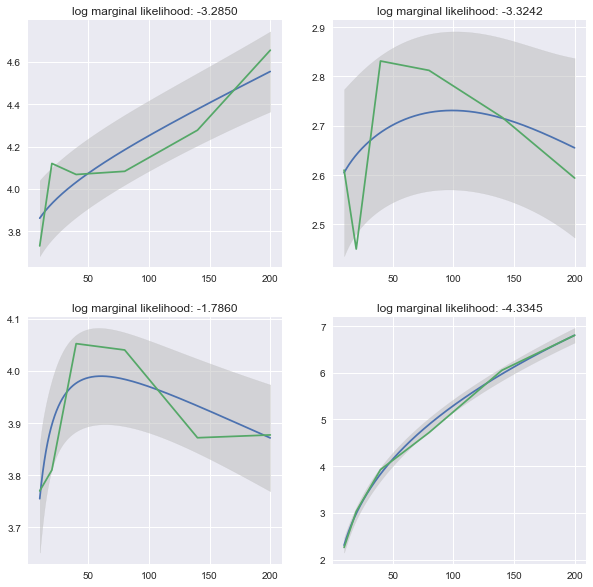

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

kernel = (
    kernels.RBF() +
    kernels.ConstantKernel() +
    kernels.Exponentiation(kernels.DotProduct(), 0.5) +
    kernels.WhiteKernel()
)

plt.figure(figsize=(10, 10))
for i, tt in enumerate([44, 351, 631, 551]):
    gpr = GaussianProcessRegressor(
        kernel, n_restarts_optimizer=50, normalize_y=True
    ).fit(
        towmetds['z'][:6].reshape(-1, 1),
        towmetds['F'][tt][:-1]
    )
    wi, std = gpr.predict(zi.reshape(-1, 1), return_std=True)

    plt.subplot(2, 2, i + 1)
    plt.title('log marginal likelihood: %.4f' % gpr.log_marginal_likelihood())
    plt.fill_between(zi, wi - std, wi + std, color='#bbbbbb', alpha=0.5)
    plt.plot(zi, wi)
    plt.plot(towmetds['z'][:6], towmetds['F'][tt][:-1])

plt.show()

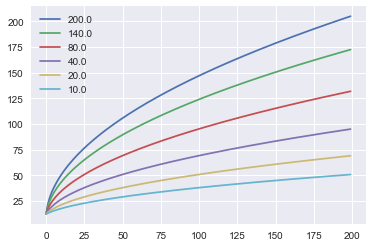

In [10]:
xx = np.arange(0, 200, 1)
kvals = gpr.kernel_(towmetds['z'][:6].reshape(-1, 1), xx.reshape(-1, 1))
for z, k in zip(towmetds['z'][:6], kvals):
    plt.plot(xx, k, label=str(z))
plt.legend()

result is pretty cool actually. sometimes the function looks too smooth (top right plot), but considering that the values differ by 0.1/0.2, that might very well be explained by noise in the measurement. the problem is that it takes *ages* to fit

In [11]:
def gpmodel(zs, ys, zpred=None):
    zpred = zpred if zpred is not None else zs

    kernel = (
        kernels.RBF() +
        kernels.ConstantKernel() +
        kernels.Exponentiation(kernels.DotProduct(), 0.5) +
        kernels.WhiteKernel()
    )

    (zs, ys), good_data = prepare_arrays(zs, ys)

    gpr = GaussianProcessRegressor(
        kernel, n_restarts_optimizer=50, normalize_y=True
    ).fit(
        zs.reshape(-1, 1), ys
    )

    eps = 0.01
    preds = gpr.predict(np.array([
        (z - eps, z, z + eps)
        for z in zpred.reshape(-1, 1)
    ]).reshape(-1, 1))

    pp = preds[1::3]
    dydz = (preds[2::3] - preds[0::3]) / (2 * eps)

    return pp, dydz

### finite differences

aka difference quotient, obtained by averaging top and bottom derivatives (quantity is $x$ and altitude is $y$)

$$
f^\prime(z)=\frac{1}{2}\cdot\left(
\frac{y_{i+1}-y_i}{z_{i+1}-z_i}+\frac{y_i-y_{i-1}}{z_i-z_{i-1}}
\right)
$$

for boundary values we can only use the previous/next measurement

$$
\frac{\partial x_0}{\partial y_0}=\frac{x_1-x_0}{y_1-y_0}
$$

~~we fill missing values with linear interpolation. this will result in the same gradient, but at least we won't throw away the value~~

we cannot use linear interpolation to fill the value, because the wind profile is not linear, and cannot be approximated like that. instead, we simply skip the value

In [12]:
ProfileData = namedtuple('ProfileData', ['z', 'measure', 'model', 'derivative'])


def prepare_arrays(*arrs):
    # replace masked values with nans
    # then remove element at position i from all arrays
    # if any of them is nan/inf
    # returns cleaned arrays and mask
    mask = np.logical_and(*[
        np.isfinite(np.ma.filled(a, np.nan))
        for a in arrs
    ])

    return [np.array(a)[mask] for a in arrs], mask


def get_derivative(xs, ys):
    # returns dydx by weighted finite differences
    # nans/infs/masked values are skipped in the computation,
    # but preserved in the output (all replaced with nans)
    
    (gxs, gys), good_data = prepare_arrays(xs, ys)

    # compute derivative with good measurements
    gdydx = []
    for i in range(len(gxs)):
        if i == 0:
            d = (gys[i] - gys[i + 1]) / (gxs[i] - gxs[i + 1])
        elif i == len(gxs) - 1:
            d = (gys[i - 1] - gys[i]) / (gxs[i - 1] - gxs[i])
        else:
            #d = (gys[i - 1] - gys[i + 1]) / (gxs[i - 1] - gxs[i + 1])
            d = 0.5 * (
                (gys[i + 1] - gys[i]) / (gxs[i + 1] - gxs[i])
                + (gys[i] - gys[i - 1]) / (gxs[i] - gxs[i - 1])
            )

        gdydx.append(d)

    # insert back nans
    dydx = np.zeros(len(xs))
    dydx[good_data] = gdydx
    dydx[~good_data] = np.nan

    return dydx

### logarithmic wind profile

another option is to model the wind as $u(z)=a+bz+cz^2+d\ln z$, with $\partial u/\partial z=b+2cz+d/z$

In [13]:
def logmodel(zs, ys, zpred=None):
    zpred = zpred if zpred is not None else zs

    (ys, zs), good_data = prepare_arrays(ys, zs)

    features = [(1, z, z**2, np.log(z)) for z in zs]

    mm = LinearRegression(normalize=True).fit(features, ys)

    pp = mm.predict([
        (1, z, z**2, np.log(z)) for z in zpred
    ])

    a, b, c, d = mm.coef_
    dydz = b + 2 * zpred * c + d / zpred

    return pp, dydz

In [14]:
def get_temp_profile(time_index, towmetds, method):
    if method not in {'fdiff', 'log', 'gp'}:
        raise ValueError('unknown method, use fidff, log, or gp')

    zs = towmetds['z'][:]
    virtual_temp = np.ma.filled(towmetds['TA'][time_index] * (
        1 + 0.61 * towmetds['Q'][time_index]
    ), np.nan)

    if method == 'fdiff':
        dtdz = get_derivative(zs, virtual_temp)
        mt = [None] * len(virtual_temp)
    else:
        compute = logmodel if method == 'log' else gpmodel
        mt, dtdz = compute(zs, virtual_temp)

    return ProfileData(z=zs, measure=virtual_temp,
                       derivative=dtdz, model=mt)


def get_wind_profile(time_index, towmetds, method):
    if method not in {'fdiff', 'log', 'gp'}:
        raise ValueError('unknown method, use fidff, log, or gp')

    zs = towmetds['z'][:]
    wind = np.ma.filled(towmetds['F'][time_index], np.nan)
    
    if method == 'fdiff':
        # use no-slip condition to get gradient at bottom level
        zs = list(zs) + [0]
        wind = list(wind) + [0]

        dwdz = get_derivative(zs, wind)
        mw = [None] * len(wind)
    else:
        compute = logmodel if method == 'log' else gpmodel
        mw, dwdz = compute(zs, wind)

    return ProfileData(z=zs, measure=wind,
                       derivative=dwdz, model=mw)

In [15]:
def plot_profile(time_index, towmetds, quantity, ax=None):
    if quantity == 'wind':
        compute = get_wind_profile
    elif quantity == 'temp':
        compute = get_temp_profile
    else:
        raise ValueError('unknown measure, use wind or temp')

    if ax is None:
        fig, ax = plt.subplots()
    
    ax2 = ax.twiny()
    for method in ['fdiff', 'log', 'gp']:
        prof = compute(time_index, towmetds, method)
        ax.plot(prof.model, prof.z, '.--', label=method)
        ax2.plot(prof.derivative, prof.z, '.-')

    ax.plot(prof.measure, prof.z, 'o-', label='measure')
    ax.legend(loc='best')

    return ax, ax2

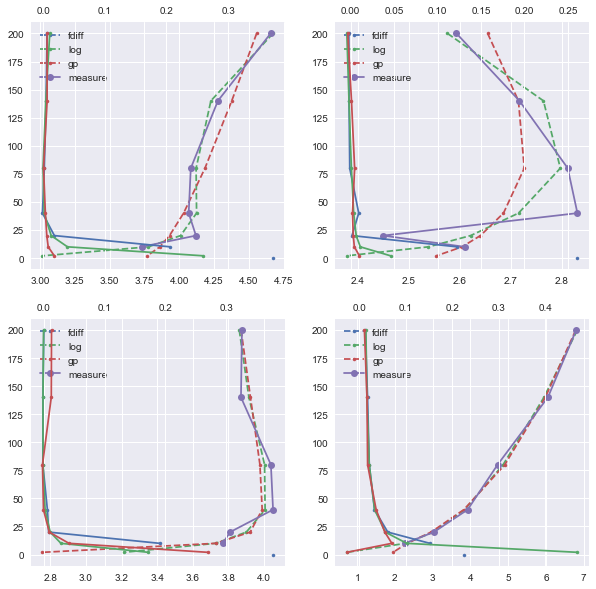

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = [a for row in axes for a in row]
for i, (ax, tt) in enumerate(zip(axes, [44, 351, 631, 551])):
    plot_profile(tt, towmetds, 'wind', ax)

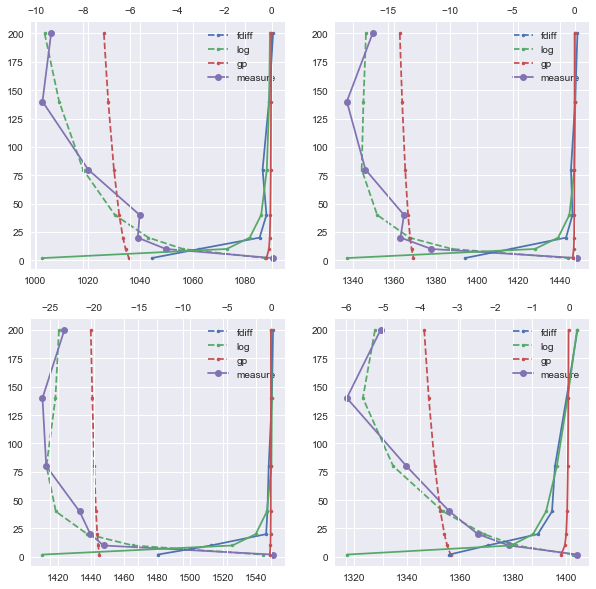

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = [a for row in axes for a in row]
for i, (ax, tt) in enumerate(zip(axes, [44, 351, 631, 551])):
    plot_profile(tt, towmetds, 'temp', ax)

## computing data

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [18]:
measurement_cols = ['air_dens', 'H', 'LE', 'ustar', 'wind', 'temp', 'virtual_temp', 'soil_temp', 'z']
index_cols = ['ds', 'year', 'month', 'daym', 'hday', 'tt', 'datetime', 'minute']
computed_cols = ['lval', 'zL', 'model_wind', 'dwdz', 'phi_m', 'model_temp', 'dtdz', 'phi_h']
source_cols = ['IUST', 'ILE', 'IH', 'ITA', 'IF', 'IP0']
additional_cols = ['dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux', 'soilheat', 'netrad']
RowRecord = namedtuple('RowRecord', index_cols + measurement_cols + computed_cols + source_cols + additional_cols)


def process(month, profile_type, **kwargs):
    try:
        towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    try:
        soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)
    except:
        soilds = None

    for time_index, tt in enumerate(towmetds['time']):
        # compute profiles
        wind_profile = get_wind_profile(time_index, towmetds, profile_type)
        temp_profile = get_temp_profile(time_index, towmetds, profile_type)

        # process each level separately
        for alt_index, z in enumerate(towmetds['z'][:]):
            if z > 50 or z < 2: # outside of the surface layer
                continue

            # retrieve profiles
            if temp_profile.z[alt_index] == z:
                vtemp = temp_profile.measure[alt_index]
                dtemp = temp_profile.derivative[alt_index]
                mtemp = temp_profile.model[alt_index]
            else:
                vtemp = dtemp = mtemp = np.nan

            if wind_profile.z[alt_index] == z:
                wind = wind_profile.measure[alt_index]
                dwind = wind_profile.derivative[alt_index]
                mwind = wind_profile.model[alt_index]
            else:
                wind = dwind = mwind = np.nan

            # compute things
            spec_hum = towmetds['Q'][time_index, alt_index]
            air_dens = 100 * meteods['P0'][time_index] / (287.058 * vtemp)  # kg.m-3

            virtual_potential_temperature_flux = (
                fluxds['H'][time_index] + 0.07 * fluxds['LE'][time_index]
            ) / (1005 * air_dens)

            lval = -fluxds['UST'][time_index]**3 * vtemp / (
                0.35 * 9.81 * virtual_potential_temperature_flux
            )  # m

            phi_m = dwind * 0.35 * z / fluxds['UST'][time_index]
            phi_h = -(
                dtemp * 0.4 * z * fluxds['UST'][time_index]
                / virtual_potential_temperature_flux
            )

            daym = int(tt / 24)
            hday = tt % 24
            minute = 60 * (hday - int(hday))
            second = 60 * (minute - int(minute))

            dt = datetime.datetime(
                year=int(month[:4]), month=int(month[4:]), day=int(daym) + 1,
                hour=int(hday), minute=int(minute), second=int(second)
            )

            yield RowRecord(
                ds=month,
                tt=tt,
                year=dt.year,
                month=dt.month,
                daym=dt.day,
                hday=dt.hour,
                minute=dt.minute,
                datetime=time.mktime(dt.timetuple()),

                air_dens=air_dens,
                H=fluxds['H'][time_index],
                LE=fluxds['LE'][time_index],
                ustar=fluxds['UST'][time_index],
                temp=towmetds['TA'][time_index, alt_index],
                virtual_temp=vtemp,
                soil_temp=(273.15 + soilds['TS00'][time_index]) if soilds else np.nan,
                wind=wind,

                z=z,
                lval=lval,
                zL=z / lval,
                model_wind=mwind,
                model_temp=mtemp,
                dwdz=dwind,
                dtdz=dtemp,
                phi_m=phi_m,
                phi_h=phi_h,

                IUST=fluxds['IUST'][time_index],
                ILE=fluxds['ILE'][time_index],
                IH=fluxds['IH'][time_index],
                ITA=towmetds['ITA'][time_index, alt_index],
                IF=towmetds['IF'][time_index, alt_index],
                IP0=meteods['IP0'][time_index],

                co2flux=fluxds['FC'][time_index],
                soilheat=fluxds['G0'][time_index],
                netrad=fluxds['QN'][time_index],
                spec_hum=spec_hum,
                dewpoint=towmetds['TD'][time_index, alt_index],
                rel_hum=towmetds['RH'][time_index, alt_index],
                press=meteods['P0'][time_index],
                rain=meteods['RAIN'][time_index],
            )

In [19]:
def get_data(dframe_path, **kwargs):
    compression = 'gzip' if dframe_path.endswith('.gz') else None
    sample_size = 7 if 'sample' in dframe_path else 0
    
    if not os.path.exists(dframe_path):
        print('recomputing data for %s (you take a coffee)' % dframe_path)
        import findspark
        findspark.init()

        from pyspark import SparkContext, SparkConf

        sc = SparkContext(conf=SparkConf()
            .setMaster('local[7]')
            .set('spark.driver.memory', '14g')
            .set('spark.driver.maxResultSize', '14g'))
        all_months = set(f[-6-3:-3] for f in os.listdir('data/cabauw') if f.endswith('.nc'))

        bad_rows = sc.accumulator(0)    
        def good_row(row):
            is_good = row.ustar > 0.1 and abs(row.H) > 10 and row.wind > 1
            if not is_good:
                bad_rows.add(1)
            return is_good

        try:
            months_rdd = sc.parallelize(all_months, len(all_months))
            if sample_size > 0:
                months_rdd = months_rdd.sample(
                    withReplacement=False,
                    fraction=sample_size / len(all_months),
                    seed=kwargs.get('seed', None)
                )

            df_rows = (months_rdd
                .flatMap(lambda month: process(month, **kwargs))
                .filter(good_row)
                .collect())
        finally:
            sc.stop()

        print(bad_rows.value, 'rows had bad data')
        print('collected', len(df_rows), 'rows of good data')

        df = pd.DataFrame(df_rows)
        df.to_csv(dframe_path, index=False,
                  compression='gzip' if dframe_path.endswith('.gz') else None)

    try:
        df = pd.read_csv(dframe_path, na_values='--')
    except (OSError, UnicodeDecodeError):
        df = pd.read_csv(dframe_path, na_values='--', compression='gzip')
    
    return df

In [36]:
df = get_data('data/cabauw/processed-full-model.csv.gz')

1929853 bad rows for the full dataset, and 1506563 good ones

we also remove data from 201603 as it contains bad measurements for the fluxes

In [185]:
df[df.ds == 201603][['H', 'LE']].describe().T

,count,mean,std,min,25%,50%,75%,max
H,9553.0,314.313909,6980.719147,-1552.988037,-46.030830,-14.380824,36.903568,287641.1250
LE,9522.0,46.359942,252.483067,-9660.833000,-17.214043,34.001152,120.266309,1549.6664


In [186]:
df = df[df.ds != 201603]
print(len(df), 'good records')

1497010 good records


In [187]:
df[additional_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
dewpoint,1492479.0,280.334578,6.124451,187.966110,276.717130,280.645450,284.675750,296.747620
spec_hum,1497010.0,6.632884,2.459633,-0.944752,4.815541,6.368880,8.306055,17.782124
rel_hum,1492479.0,76.571399,15.187257,0.003741,67.027807,79.165760,88.255507,133.698460
press,1497010.0,1014.284660,9.831901,960.900024,1008.500000,1014.900024,1020.799988,1046.400024
rain,1497010.0,0.016086,0.125476,-0.016667,0.000000,0.000000,0.000000,15.100000
co2flux,1497010.0,-0.064211,0.296601,-7.483615,-0.247179,0.033376,0.117143,6.102142
soilheat,1497010.0,2.670725,14.856866,-69.496613,-6.429231,-0.709898,8.451236,1138.953857
netrad,1497010.0,80.779777,166.318715,-158.464615,-35.564087,-3.004395,170.390320,7775.445312


In [188]:
df[measurement_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
air_dens,1497010.0,0.275544,0.123663,0.100890,0.201426,0.253524,0.319612,2.833936
H,1497010.0,3.446906,47.303138,-459.999756,-25.957153,-14.836812,27.863348,479.642334
LE,1497010.0,74.272851,114.336003,-534.843600,-4.915475,23.696733,131.712252,6940.750000
ustar,1497010.0,0.308339,0.148096,0.100000,0.197972,0.281547,0.386364,1.778369
wind,1497010.0,5.859229,2.658946,1.000041,3.977110,5.420000,7.228647,29.387110
temp,1497010.0,284.735833,6.388327,259.649994,280.149994,284.750000,289.350006,306.850006
virtual_temp,1497010.0,1444.638666,455.716901,124.793495,1104.776306,1392.017151,1753.759491,3506.047363
soil_temp,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z,1497010.0,23.336350,12.472423,10.000000,10.000000,20.000000,40.000000,40.000000


In [189]:
df[computed_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
lval,1497010.0,131.414990,6711.647743,-1.312652e+06,-24.947409,26.022632,137.743184,3.995551e+06
zL,1497010.0,-0.071537,1.968585,-1.042494e+02,-0.219233,0.061414,0.352411,2.925918e+01
model_wind,1497010.0,5.863469,2.658050,5.445866e-01,3.986043,5.429083,7.231588,2.948378e+01
dwdz,1497010.0,0.061112,0.045755,-3.074057e-01,0.030981,0.053889,0.081265,8.532897e-01
phi_m,1497010.0,1.622303,1.514027,-9.456479e+00,0.675311,1.157474,2.051269,1.503653e+01
model_temp,1497010.0,1445.113142,454.929330,-1.090825e+02,1104.435563,1392.150323,1753.461539,3.451073e+03
dtdz,1497010.0,-0.859261,2.609634,-9.633443e+01,-1.293784,-0.567828,-0.177772,1.014841e+02
phi_h,1497010.0,-5.002983,1377.661548,-8.958161e+05,-14.743421,-0.061773,10.922693,3.321678e+05


In [190]:
df[index_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ds,1497010.0,2.009268e+05,4.722258e+02,200108.0,2.005080e+05,2.009080e+05,2.013100e+05,2.017120e+05
year,1497010.0,2.009203e+03,4.722869e+00,2001.0,2.005000e+03,2.009000e+03,2.013000e+03,2.017000e+03
month,1497010.0,6.512820e+00,3.429097e+00,1.0,4.000000e+00,6.000000e+00,1.000000e+01,1.200000e+01
daym,1497010.0,1.568102e+01,8.805245e+00,1.0,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01
hday,1497010.0,1.163888e+01,6.536612e+00,0.0,7.000000e+00,1.200000e+01,1.700000e+01,2.300000e+01
tt,1497010.0,3.644002e+02,2.114277e+02,0.0,1.811667e+02,3.626667e+02,5.455000e+02,7.438334e+02
datetime,1497010.0,1.252891e+09,1.491268e+08,996616800.0,1.124362e+09,1.250390e+09,1.383031e+09,1.514761e+09
minute,1497010.0,2.489946e+01,1.705578e+01,0.0,1.000000e+01,3.000000e+01,4.000000e+01,5.000000e+01


In [191]:
df[source_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
IUST,1497010.0,2.252821,0.685347,2.0,2.0,2.0,2.0,7.0
ILE,1497010.0,2.454625,1.276517,2.0,2.0,2.0,2.0,7.0
IH,1497010.0,2.405008,1.195696,2.0,2.0,2.0,2.0,7.0
ITA,1497010.0,2.045534,0.444444,2.0,2.0,2.0,2.0,7.0
IF,1497010.0,2.025660,0.338340,2.0,2.0,2.0,2.0,7.0
IP0,1497010.0,3.031230,0.346922,3.0,3.0,3.0,3.0,7.0


## Compare gradients computed with weighted finite differences and log profile model

In [25]:
log_df = get_data('data/cabauw/processed-sample-log.csv.gz', profile_type='log', seed=54321)
fd_df = get_data('data/cabauw/processed-sample-fd_fd.csv.gz', profile_type='fdiff', seed=54321)
#gp_df = get_data('data/cabauw/processed-sample-gp.csv.gz', profile_type='gp', seed=54321)

merged = log_df.merge(fd_df, on=['ds', 'tt', 'z'], suffixes=('_log', '_fd'))

recomputing data for data/cabauw/processed-sample-log.csv.gz (you take a coffee)
78364 rows had bad data
collected 62756 rows of good data
recomputing data for data/cabauw/processed-sample-fd_fd.csv.gz (you take a coffee)
78364 rows had bad data
collected 62756 rows of good data


compute r squared between measured wind and modeled wind

In [27]:
merged = merged.groupby(['ds', 'tt']) \
    .apply(lambda g: r2_score(g.wind_log, g.model_wind_log)) \
    .reset_index().rename({0: 'model_wind_r2'}, axis=1) \
    .merge(merged, on=['ds', 'tt'])

merged.model_wind_r2.describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75])

count    62756.000000
mean         0.621334
std         36.396598
min      -6425.764953
1%          -0.773595
2.5%        -0.028875
5%           0.417132
10%          0.738039
25%          0.933341
50%          0.979996
75%          0.993898
max          0.999999
Name: model_wind_r2, dtype: float64

note: here we are computing the r-squared considering only the levels 10/20/40, which are the most sensitive. the r-squared on all levels has a much lighter left tail, with the minimum being between -10 and 0, but there is not much difference in distribution otherwise. using only the three levels is more relevant in our case tho, since we want to compare with finite differences on these levels only

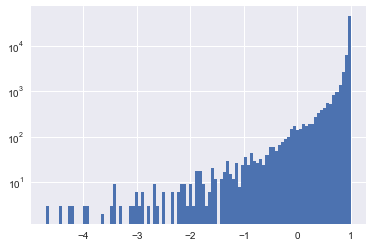

In [28]:
r2_filter = merged.model_wind_r2 > -5
_ = plt.hist(merged[r2_filter].model_wind_r2, bins=100)
plt.yscale('log')

plot the r squared of the modeled wind against the difference between modeled gradient and finite differences gradient

(-5, 1.5)

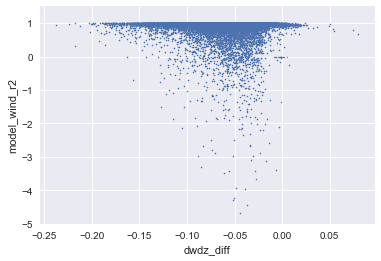

In [29]:
merged.assign(dwdz_diff=lambda df: df.dwdz_log - df.dwdz_fd) \
    .groupby(['ds', 'tt']) \
    .dwdz_diff.mean() \
    .reset_index() \
    .merge(merged, on=['ds', 'tt']) \
    .plot.scatter('dwdz_diff', 'model_wind_r2', s=1)
plt.ylim(-5, 1.5)

the modeled wind is not well correlated with the true wind when the modeled gradient is about 0.05 less than the f.d. gradient

plot the correlation between the two gradients, green is z=10, blue is z=20 and z=40

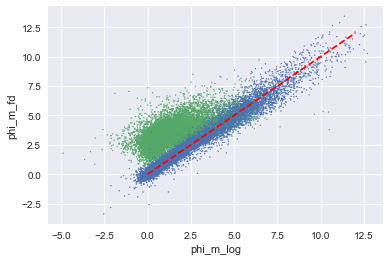

In [30]:
merged.plot.scatter('phi_m_log', 'phi_m_fd', s=1, c=[
    'C0' if z > 10 else 'C1'  for z in merged.z
])
plt.plot([0, 12], [0, 12], 'r--')

In [31]:
merged.groupby('z').apply(lambda g: (
    r2_score(g.phi_m_log, g.phi_m_fd),
    np.corrcoef(g.phi_m_log, g.phi_m_fd)[0, 1]
))

z
10.0    (-4.305116448769423, 0.6704139803107413)
20.0     (0.9756221736504855, 0.988654442229943)
40.0    (0.9621936699855016, 0.9812370561779297)
dtype: object

gradients are poorly correlated at z=10. we can check the model mse to see if the model is wrong

In [33]:
merged.groupby('z').apply(lambda g: ((g.model_wind_log - g.wind_log)**2).describe())

,count,mean,std,min,25%,50%,75%,max
z,,,,,,,,
10.0,20907.0,0.004631,0.014318,1.985024e-12,0.000263,0.001297,0.004413,1.331548
20.0,20923.0,0.021829,0.071706,2.927712e-11,0.001315,0.006377,0.021601,6.707925
40.0,20926.0,0.011434,0.035564,1.505756e-11,0.000714,0.003395,0.011252,1.928991


at z=10m the model does not seem to be off. therefore, it is reasonable to conclude that the finite differences method is not reliable at that level. in fact, because of the no-slip condition, the derivative at z=10 is computed as the wind at z=20 divided by 20

now we check in which conditions we have bad r-squared by binning wind into the intervals (1,2), (2,3), (3,)

In [34]:
merged.groupby(
    np.digitize(merged.wind_log, [1, 2, 3])
)[['model_wind_r2', 'zL_log', 'wind_log']].describe(percentiles=[]).T

1            2             3
model_wind_r2 count  2016.000000  6350.000000  54390.000000
              mean     -6.723403     0.463849      0.911958
              std     202.404882     8.260349      0.809218
              min   -6425.764953  -369.427687    -98.214490
              50%       0.699103     0.951747      0.982744
              max       0.999931     0.999989      0.999999
zL_log        count  2016.000000  6350.000000  54390.000000
              mean     -4.086197    -1.380304      0.066107
              std       4.593003     3.241193      1.230055
              min     -39.514514   -40.522406    -34.128174
              50%      -2.623226    -0.672914      0.037980
              max       3.107290     5.025524      9.015882
wind_log      count  2016.000000  6350.000000  54390.000000
              mean      1.612072     2.580167      5.695129
              std       0.259876     0.281515      2.022851
              min       1.004776     2.000000      3.000000
              50%       1.650000     2.610000      5.280000
              max       1.999983     2.999893     19.028463

low r2 scores occur in low wind conditions

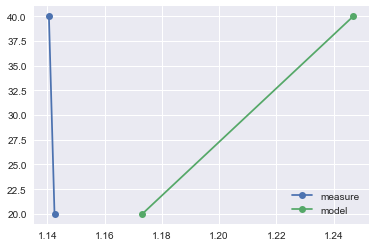

In [37]:
minr2 = merged.iloc[merged.model_wind_r2.idxmin()]
minr2 = df[(df.ds == minr2.ds) & (df.tt == minr2.tt)]
plt.plot(minr2.wind, minr2.z, 'o-', label='measure')
plt.plot(minr2.model_wind, minr2.z, 'o-', label='model')
plt.legend()

this happens when the wind is roughly constant at 10/20/40, then it has a very low std. which blows up the r2. note that we are modeling the wind at all levels, that's why the model is very far from the actual value

arguably, the most accurate method of computing the gradient is the one that works better under the MOST

In [38]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 19.3 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

log_mse = np.mean((log_df.phi_m - np.array(list(map(phi_m, log_df.zL))))**2)
fd_mse = np.mean((fd_df.phi_m - np.array(list(map(phi_m, fd_df.zL))))**2)
fd_10_mse = np.mean((fd_df[fd_df.z > 10].phi_m - np.array(list(map(phi_m, fd_df[fd_df.z > 10].zL))))**2)

print('MSE with model:', log_mse)
print('MSE with finite differences:', fd_mse)
print('MSE with finite differences without z=10:', fd_10_mse)

MSE with model: 7.359217692300299
MSE with finite differences: 8.252415190708863
MSE with finite differences without z=10: 10.338704296958403


to conclude, log model works better (despite in theory it only applies to stable conditions), and allows us to use z=10, increasing available data by almost 50%

## check correlations to see if things make sense

plot correlation matrix between data, computed values, and time of year (to check seasonality)

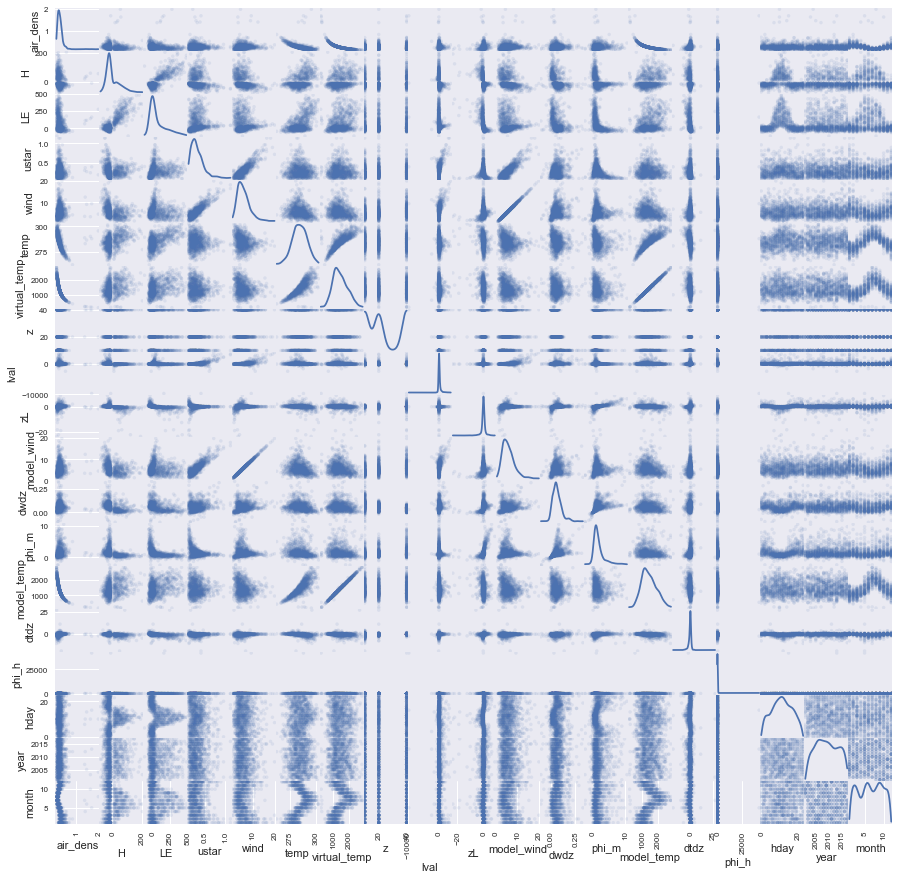

In [192]:
_ = pd.plotting.scatter_matrix(
    df.sample(1000)[measurement_cols + computed_cols + ['hday', 'year', 'month']].drop('soil_temp', axis=1),
    figsize=(15, 15), alpha=0.1, diagonal='kde'
)

## check $\phi_m$

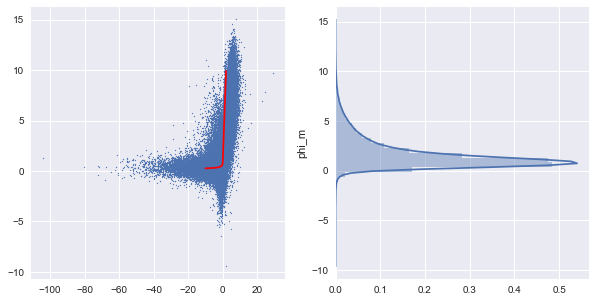

In [193]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)
xx = np.arange(-10, 2, 0.1)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
#plt.xlim(-10, 10)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_m.dropna(), vertical=True)

plt.show()

In [121]:
log_df.phi_m.std()

1.4046527646111924

In [122]:
fd_df.phi_m.std()

1.5663090159882078

looks wrong but it actually is correct, as the MOST is valid with z/L<1 or so, afterwards the curve levels off and becomse independent from it (citation somewhere)

(-2, 10)

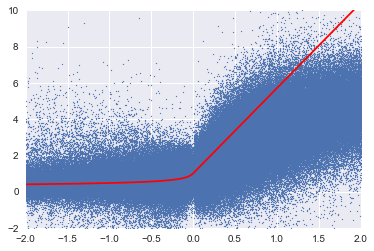

In [208]:
xx = np.arange(-50, 10, 0.01)
phimx = list(map(phi_m ,xx))
plt.scatter(df.zL, df.phi_m, s=1)
plt.plot(xx, phimx, 'r-')
plt.xlim(-2, 2)
plt.ylim(-2, 10)

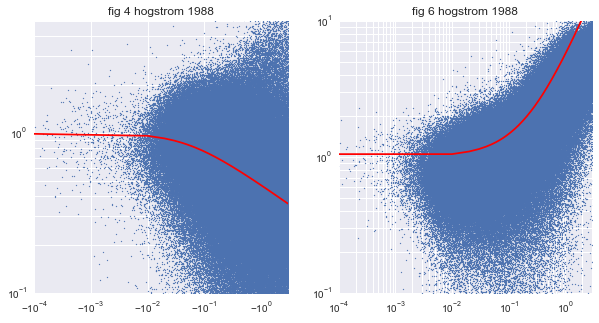

In [195]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)

plt.plot(xx, phimx, 'r')
plt.xlim(-3, -0.0001)
plt.xscale('symlog', linthreshx=0.0001)
plt.ylim(0.1, 5)
plt.yscale('log')
plt.title('fig 4 hogstrom 1988')
plt.gca().invert_xaxis()
plt.grid(True, 'both')

plt.subplot(1, 2, 2)
plt.scatter(df.zL, df.phi_m, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(0.0001, 3)
plt.xscale('log')
plt.ylim(0.1, 10)
plt.yscale('log')
plt.title('fig 6 hogstrom 1988')
plt.grid(True, 'both')
plt.show()

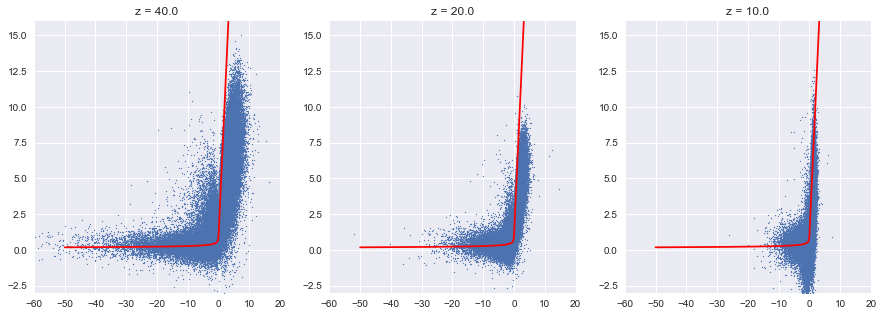

In [211]:
plt.figure(figsize=(15, 5))
for i, z in enumerate(df.z.unique()):
    plt.subplot(1, 3, i + 1)
    plt.title('z = %.1f' % z)
    plt.scatter(df[df.z == z].zL, df[df.z == z].phi_m, s=1)
    plt.plot(xx, phimx, 'r')
    plt.xlim(-60, 20)
    plt.ylim(-3, 16)

plt.show()

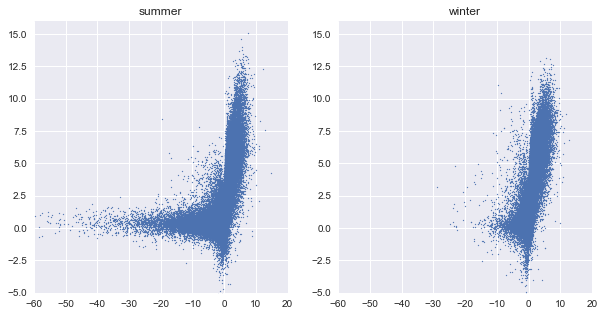

In [198]:
winter = [11, 12, 1, 2]
summer = [6, 7, 8]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('summer')
plt.scatter(df[df.month.isin(summer)].zL, df[df.month.isin(summer)].phi_m, s=1)
plt.xlim(-60, 20)
plt.ylim(-5, 16)

plt.subplot(1, 2, 2)
plt.title('winter')
plt.scatter(df[df.month.isin(winter)].zL, df[df.month.isin(winter)].phi_m, s=1)
plt.xlim(-60, 20)
plt.ylim(-5, 16)
plt.show()

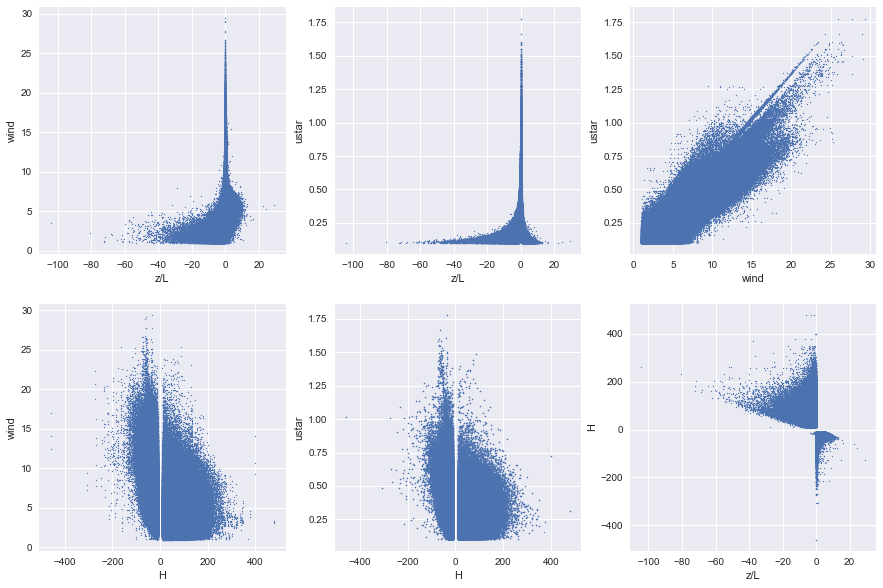

In [199]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.ylabel('wind'); plt.xlabel('z/L')
plt.scatter(df.zL, df.wind, s=1)

plt.subplot(2, 3, 2)
plt.ylabel('ustar'); plt.xlabel('z/L')
plt.scatter(df.zL, df.ustar, s=1)

plt.subplot(2, 3, 3)
plt.scatter(df.wind, df.ustar, s=1)
plt.ylabel('ustar'); plt.xlabel('wind')

plt.subplot(2, 3, 4)
plt.scatter(df.H, df.wind, s=1)
plt.xlabel('H'); plt.ylabel('wind')

plt.subplot(2, 3, 5)
plt.scatter(df.H, df.ustar, s=1)
plt.xlabel('H'); plt.ylabel('ustar')

plt.subplot(2, 3, 6)
plt.scatter(df.zL, df.H, s=1)
plt.ylabel('H'); plt.xlabel('z/L')
plt.show()

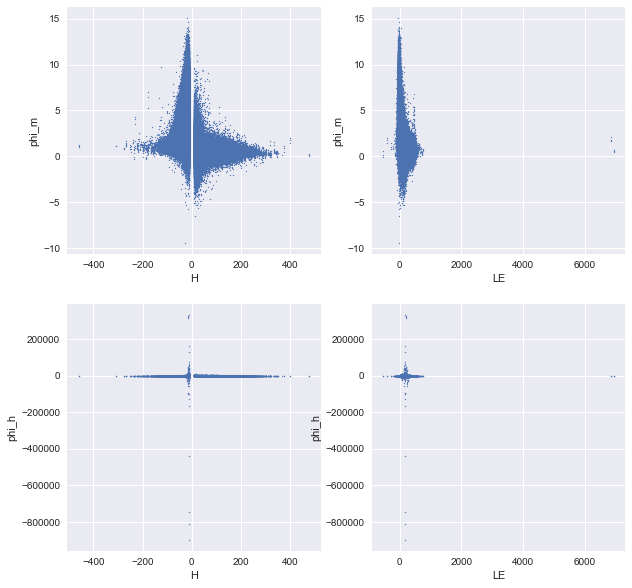

In [200]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.xlabel('H'); plt.ylabel('phi_m')
plt.scatter(df.H, df.phi_m, s=1)
plt.subplot(2, 2, 2); plt.xlabel('LE'); plt.ylabel('phi_m')
plt.scatter(df.LE, df.phi_m, s=1)
plt.subplot(2, 2, 3); plt.xlabel('H'); plt.ylabel('phi_h')
plt.scatter(df.H, df.phi_h, s=1)
plt.subplot(2, 2, 4); plt.xlabel('LE'); plt.ylabel('phi_h')
plt.scatter(df.LE, df.phi_h, s=1)
plt.show()

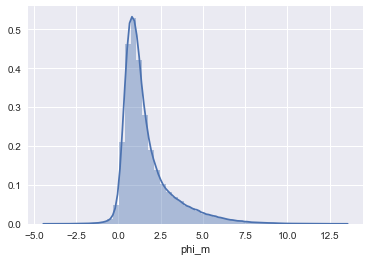

In [52]:
sns.distplot(df.phi_m.dropna())
plt.xlabel('phi_m')
plt.show()

we can compare the CDF of the variables by creating groups based on the range of $\phi_m$. we select the interval (0, 1) because it (supposedly) contains values of phi_m for unstable conditions

In [187]:
ints = [-3, 0, 1, 2, 4, 25]
print('interv.\tcount')
for low, high in zip(ints[:-1], ints[1:]):
    count = len(df[(df.phi_m >= low) & (df.phi_m < high)])
    print('[%d,%d)\t%d' % (low, high, count))

interv.	count
[-3,0)	1662
[0,1)	25286
[1,2)	12276
[2,4)	6406
[4,25)	2881


In [45]:
def plot_cdf(rvars, labels=None, ordinal=False):
    ''' plot the empirical cdf and a boxplot of multple random variables
        in the same chart, to ease comparison

        rvars contains a list of samples for each r.v.
        labels contains a label for each r.v.
    '''
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax1 = plt.subplot(gs[0])

    if ordinal:
        all_levels = sorted(set(v for var in rvars for v in var))
        level_map = dict(zip(all_levels, range(len(all_levels))))
        inv_level_map = dict(zip(range(len(all_levels)), all_levels))
        rvars = [list(map(level_map.get, var)) for var in rvars]

    for i, values in enumerate(rvars):
        xx = sorted(values)
        yy = np.arange(len(values)) / len(values)
        lbl = labels[i] if labels is not None else None
        
        ax1.plot(xx, yy, label=lbl)

    if labels is not None:
        ax1.legend()

    ax2 = plt.subplot(gs[1])
    sns.boxplot(data=rvars, ax=ax2, orient='h')

    if ordinal:
        ticklb = [
            # ticks are float, get label only on integral ticks
            (inv_level_map.get(int(t), '') if abs(int(t) - t) < 1e-9 else '')
            for t in ax1.get_xticks()
        ]

        ax1.set_xticklabels(ticklb)
        ax2.set_xticklabels(ticklb)

    return ax1, ax2


def inspect_col(colname, partition_by, interval, show=True, fig=None):
    old_pal = sns.color_palette()
    sns.set_palette('GnBu_d')

    vs = [
        df[colname][
            (df[partition_by] >= low) &
            (df[partition_by] < high)
        ].dropna()
        for low, high in zip(interval[:-1], interval[1:])
    ]

    if fig is None:
        fig = plt.figure(figsize=(7, 5))

    ax1, ax2 = plot_cdf(
        vs, list(map(str, zip(interval[:-1], interval[1:]))),
        ordinal=colname in source_cols + ['ds']
    )
    ax1.set_title(colname)
    sns.set_palette(old_pal)
    
    if show:
        plt.show()
    
    return fig, ax1, ax2

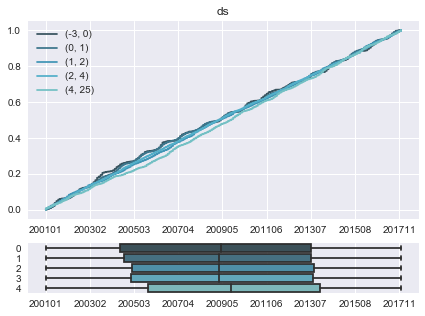

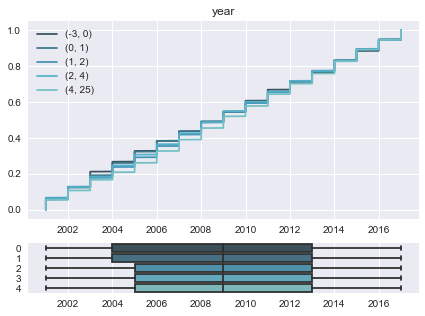

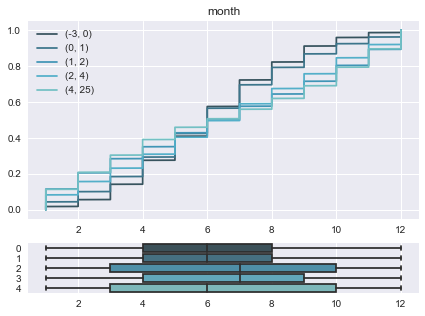

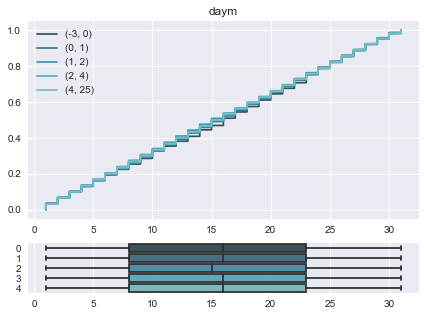

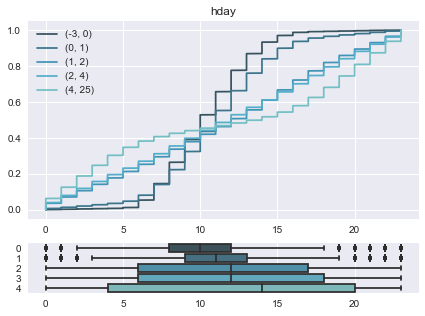

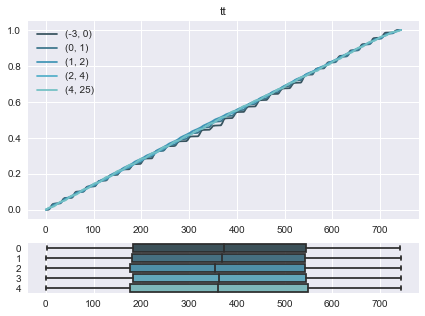

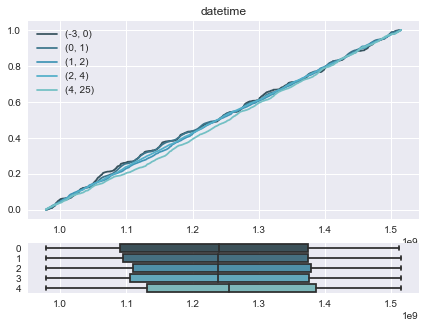

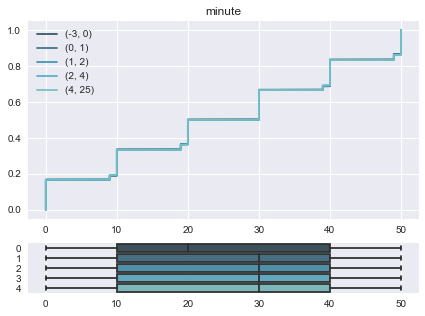

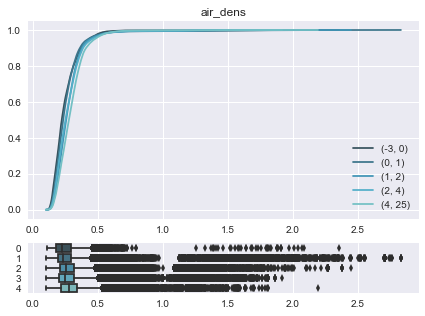

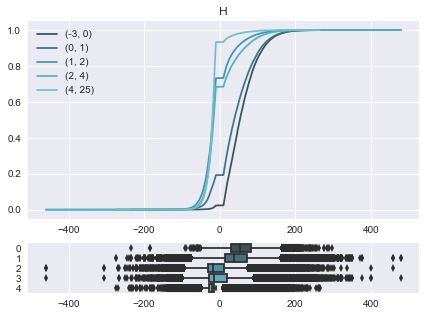

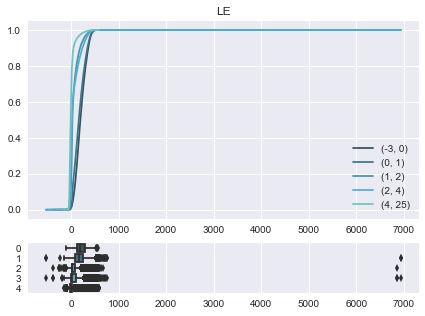

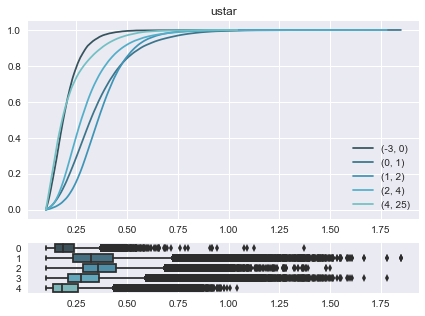

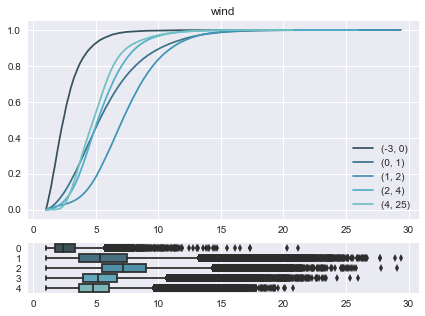

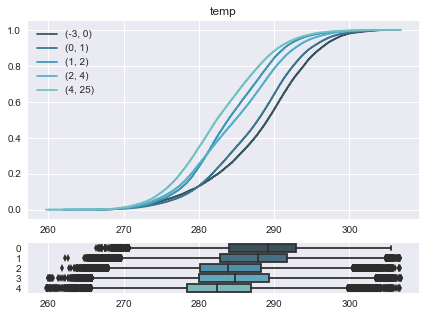

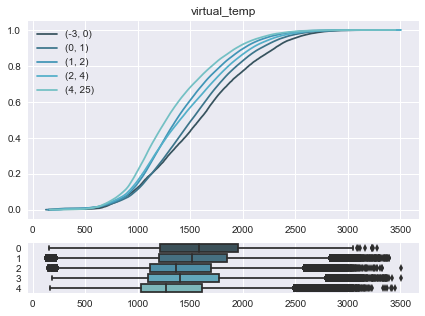

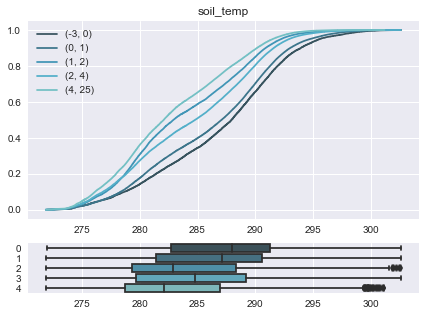

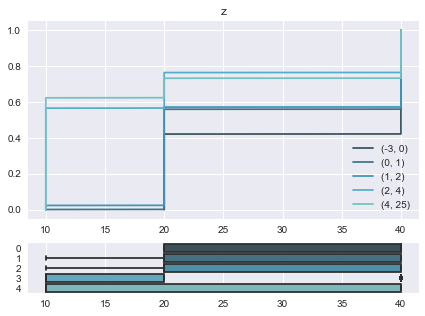

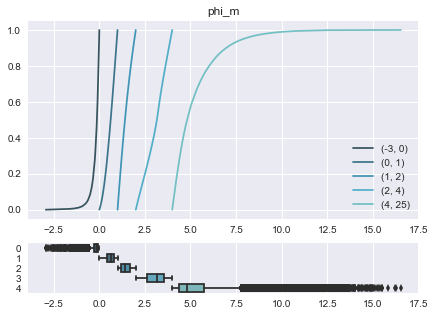

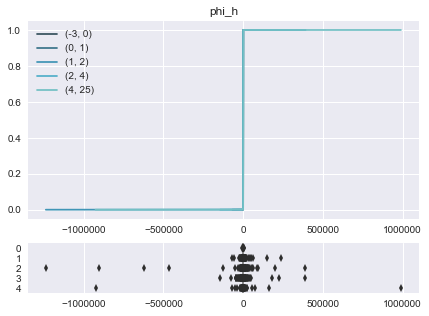

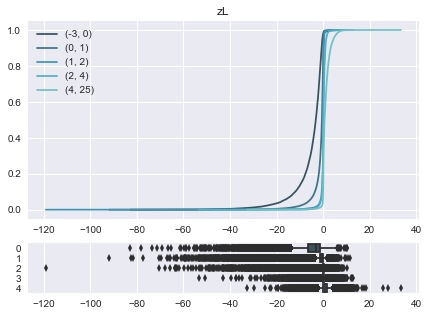

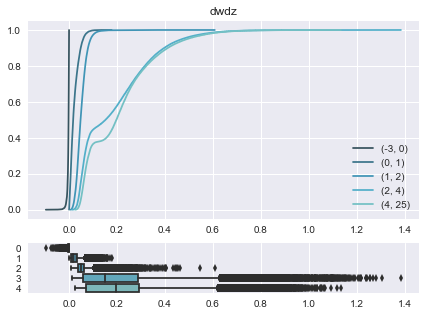

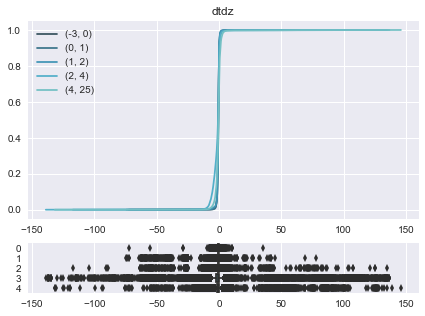

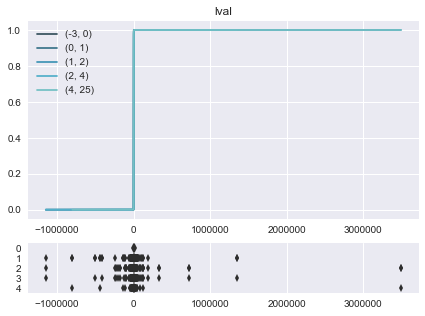

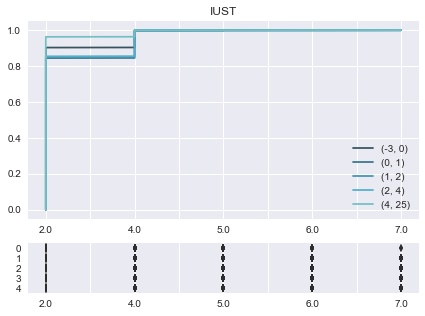

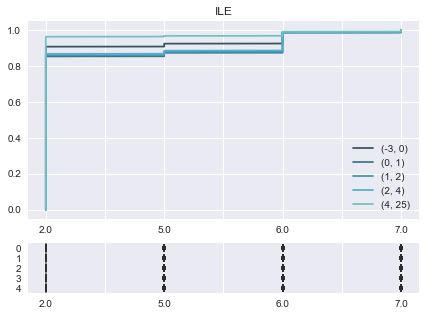

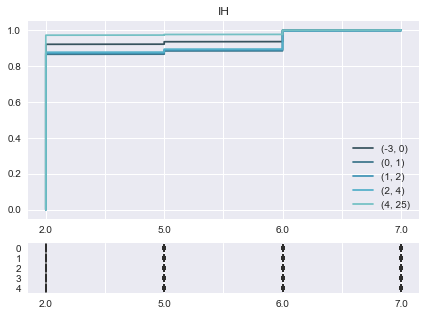

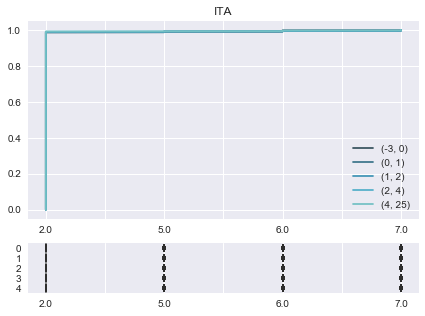

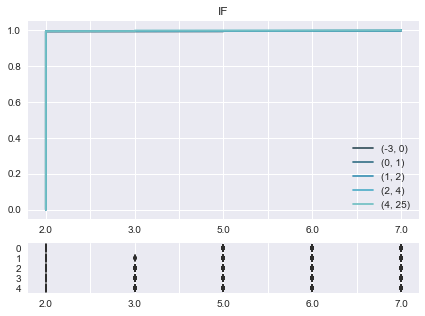

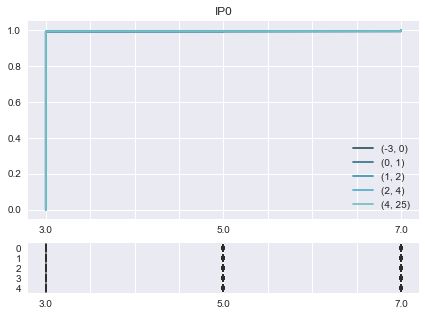

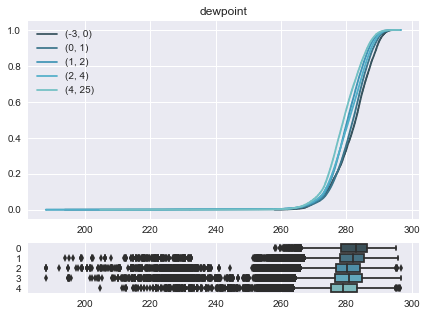

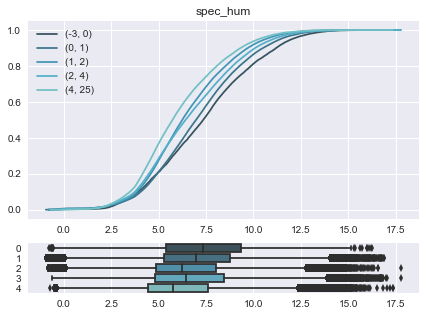

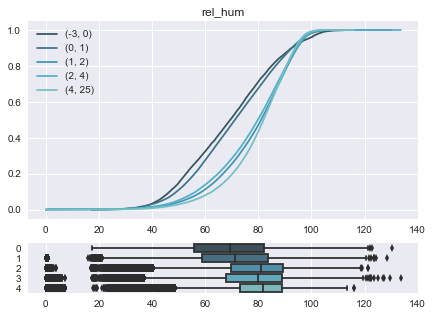

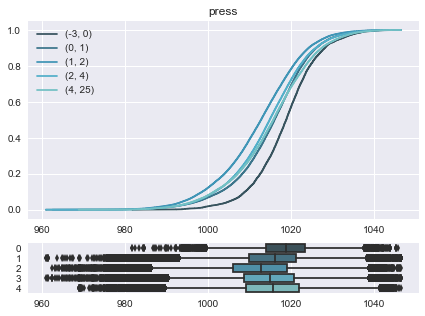

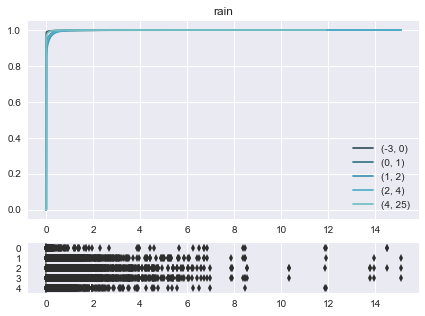

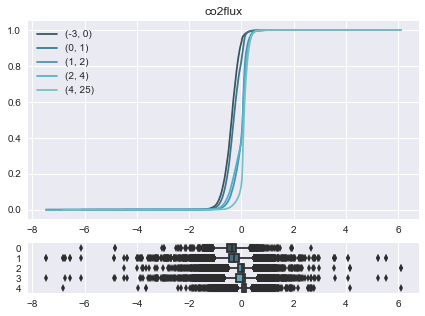

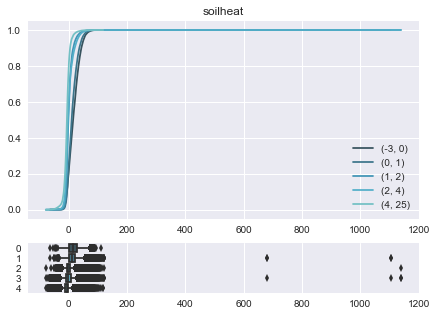

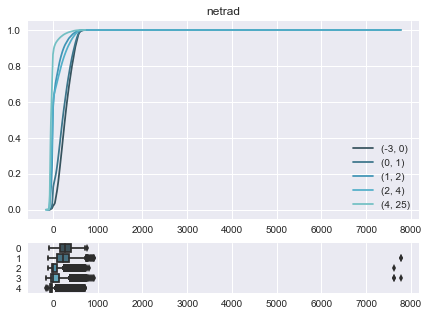

In [32]:
for col in df.columns:
    inspect_col(col, 'phi_m', ints)

seems like the source of the data (I-columns) does not play a big role in differentiating the phi levels

we see larger $\phi_m$s associated with
 - spring
 - night hours
 - denser air
 - colder temperature both soil and air
 - mainly z=10
 - high wind gradient
 - lower heat fluxes and radiation
 - higher relative humidity (both lower specific humidity and dewpoint, the former decreasing faster than the latter)

this is consistent with what we would expect, as $\phi_m$ is expected to be higher in stable condtions

highest $u_*$ in moderately stable conditions, low values in unstable and highly stable conditions; this makes sense, because in unstable conditions most tke comes from eddy fluxes caused by buoyancy, and in very stable conditions we have a calm surface layer with little turbulence. in both cases wind shear does not generate much turbulence

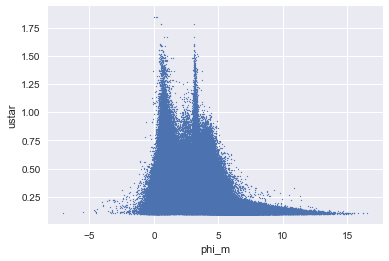

In [33]:
df.plot.scatter('phi_m', 'ustar', s=1)

## inspect z/L

In [223]:
df.zL.describe()

count    1.497010e+06
mean    -7.153704e-02
std      1.968585e+00
min     -1.042494e+02
25%     -2.192331e-01
50%      6.141402e-02
75%      3.524112e-01
max      2.925918e+01
Name: zL, dtype: float64

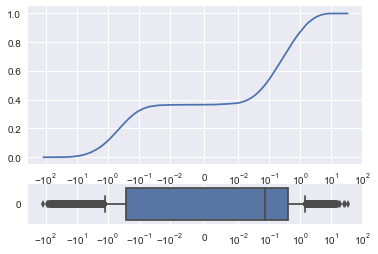

In [36]:
ax1, ax2 = plot_cdf([df.zL], labels=None)
ax1.set_xscale('symlog', linthreshx=1e-2)
ax2.set_xscale('symlog', linthreshx=1e-2)

In [37]:
bins = [
    -120, -1, 0, 1, 50
]

(df.zL.groupby(np.digitize(df.zL, bins))
     .size().rename(lambda b: '[%6.0e, %6.0e)' % (bins[b - 1], bins[b])))

[-1e+02, -1e+00)    176287
[-1e+00,  0e+00)    390887
[ 0e+00,  1e+00)    790586
[ 1e+00,  5e+01)    194660
Name: zL, dtype: int64

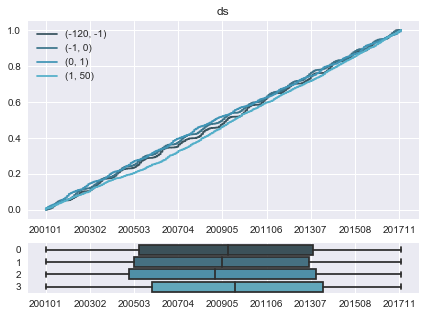

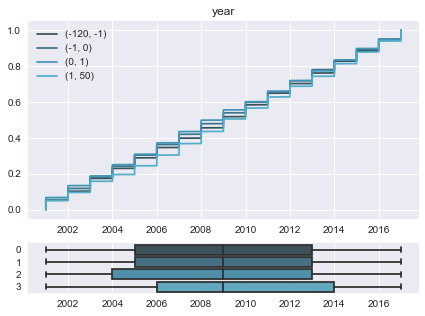

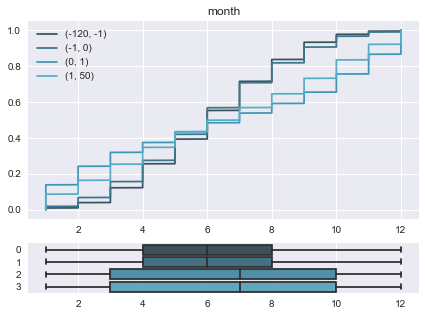

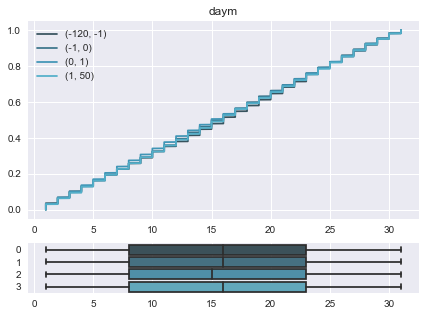

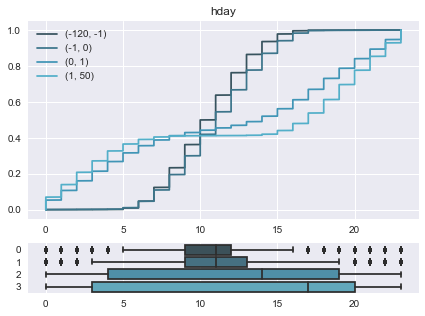

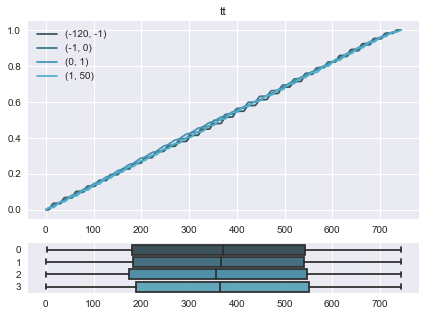

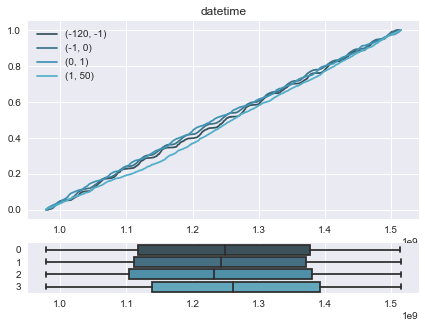

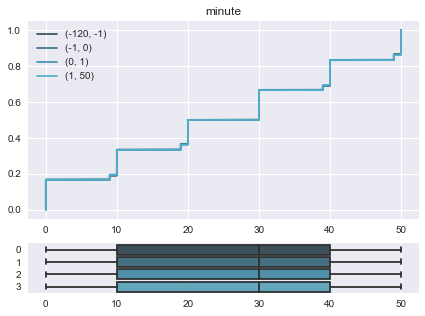

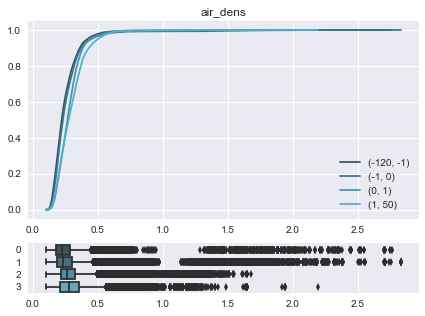

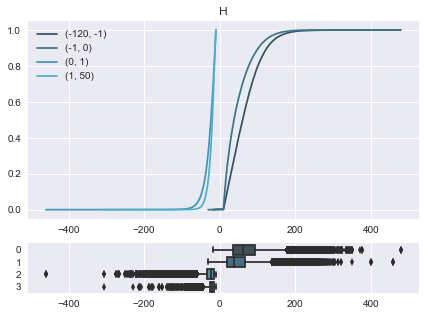

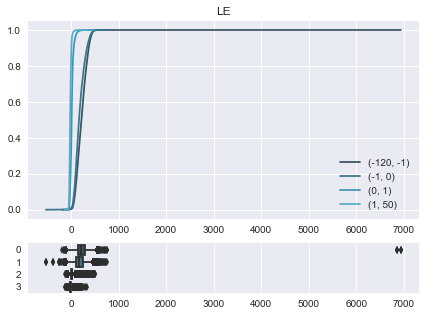

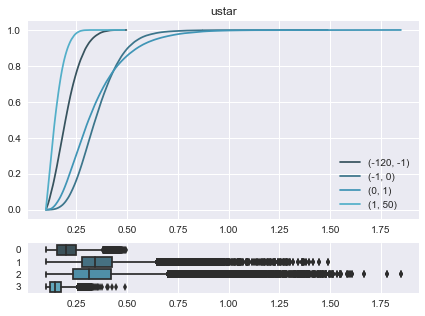

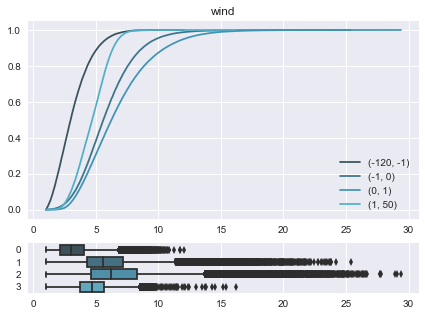

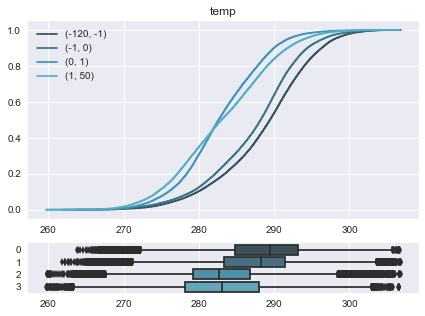

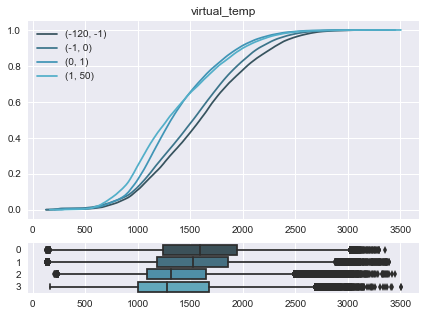

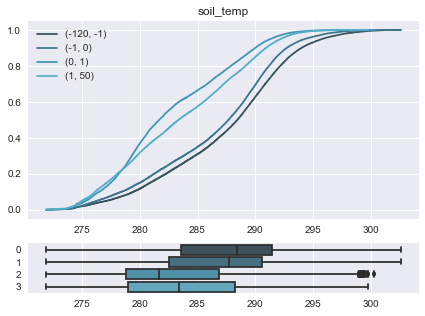

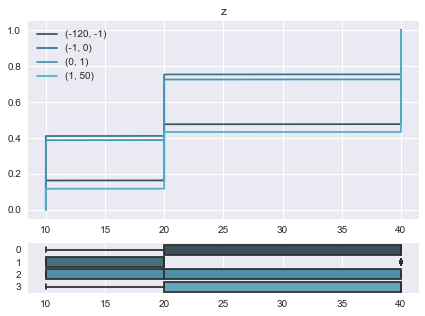

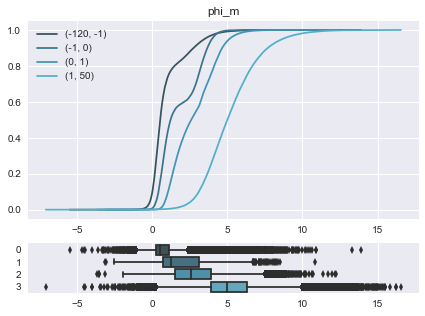

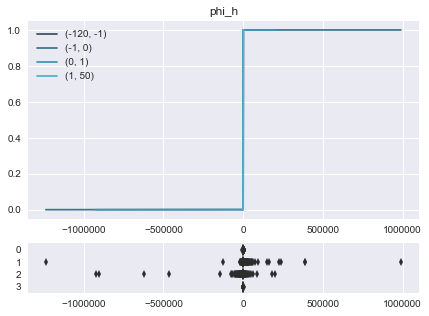

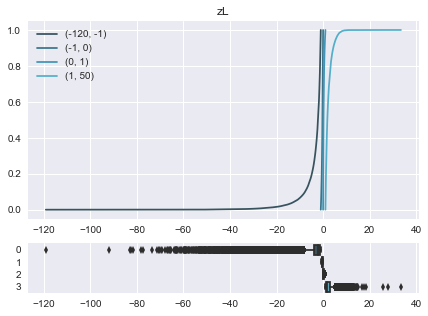

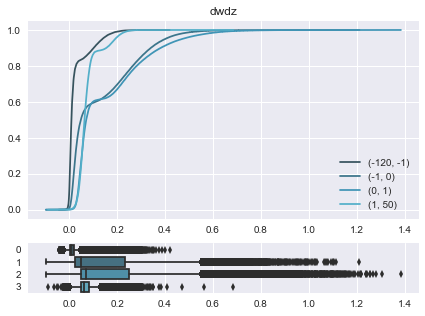

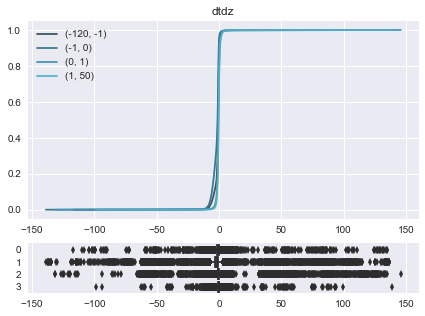

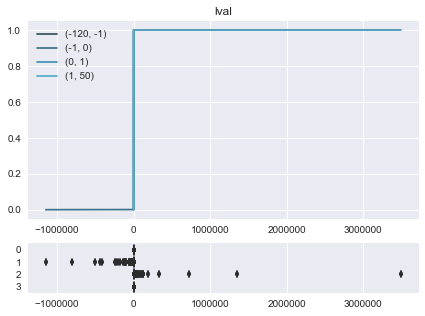

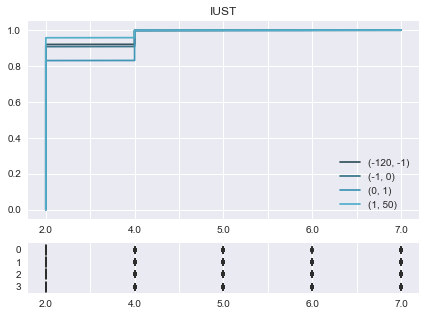

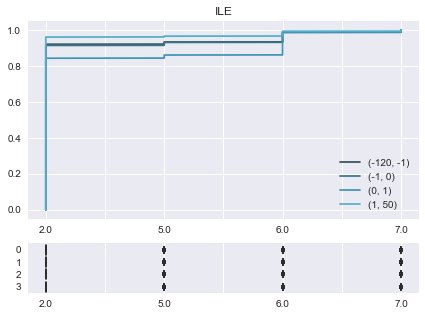

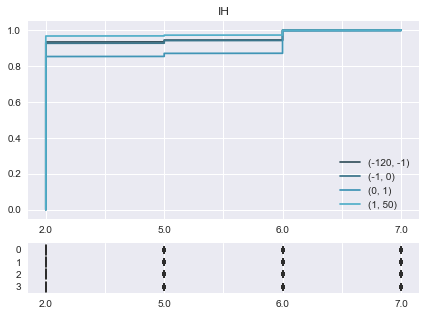

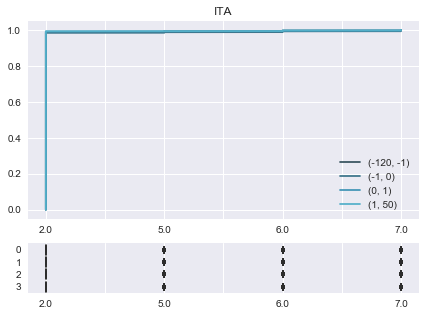

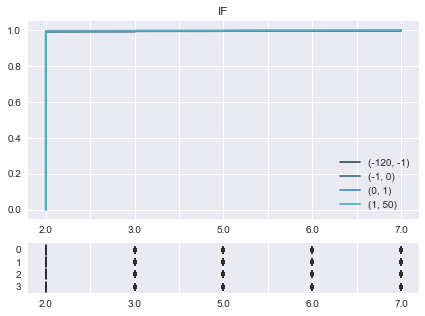

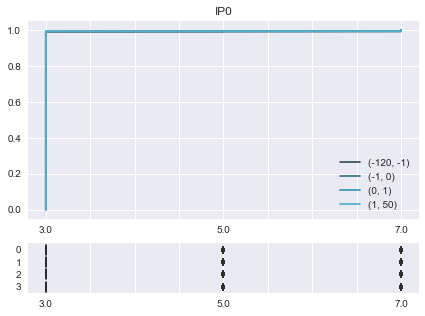

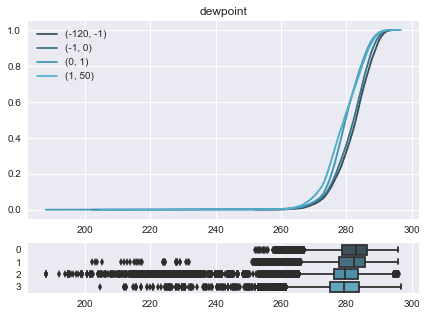

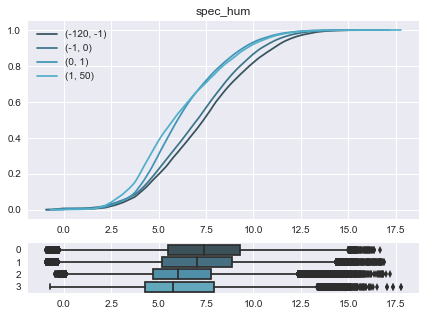

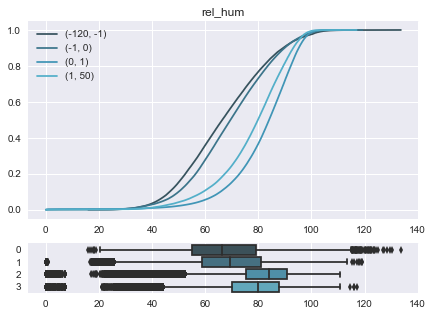

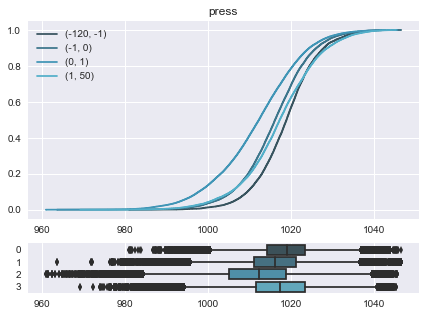

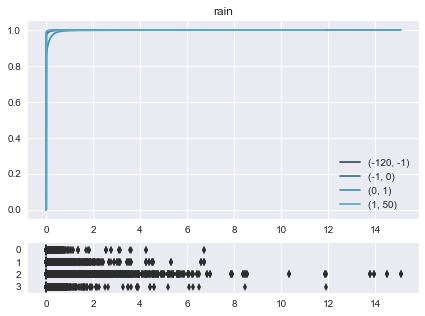

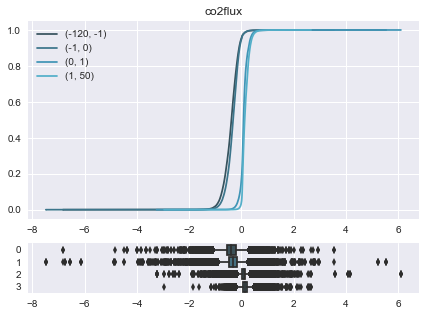

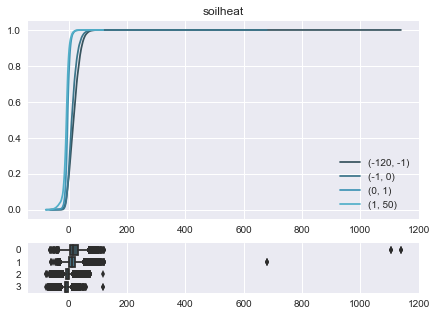

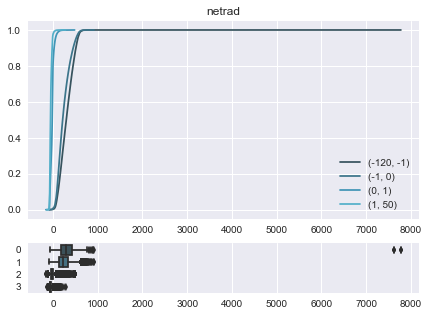

In [38]:
for col in df.columns:
    inspect_col(col, 'zL', bins)

In [39]:
(df.groupby(np.digitize(df.zL, bins))
     [['ustar', 'wind', 'LE', 'temp', 'phi_m']].mean()
     .rename(lambda b: '[%6.0f, %6.0f)' % (bins[b - 1], bins[b])))

,ustar,wind,LE,temp,phi_m
"[ -120, -1)",0.206013,3.205570,220.003459,288.704638,0.941135
"[ -1, 0)",0.357645,5.864532,181.544207,287.337700,1.826083
"[ 0, 1)",0.344723,6.728101,12.771379,282.893281,2.774353
"[ 1, 50)",0.152405,4.703470,-20.926398,283.130343,5.236304


## $\phi_h$

(-5, 30)

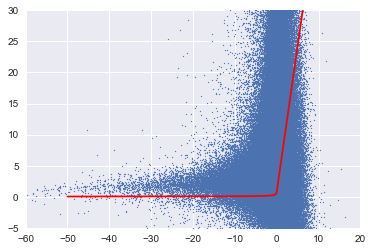

In [216]:
plt.scatter(df.zL, df.phi_h, s=1)
plt.plot(xx, list(map(phi_h, xx)), 'r')
plt.xlim(-60, 20)
plt.ylim(-5, 30)

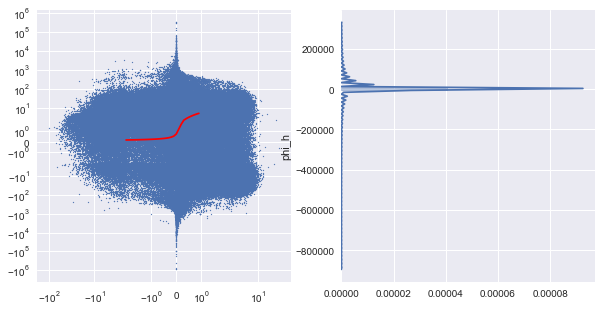

In [220]:
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL

    
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
xx  = np.arange(-2, 1, 0.1)
plt.scatter(df.zL, df.phi_h, s=1)
plt.plot(xx, list(map(phi_h, xx)), 'r')
plt.xscale('symlog')
plt.yscale('symlog')
#plt.xlim(-2, 1)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_h.dropna(), vertical=True)
plt.show()

seems wrong

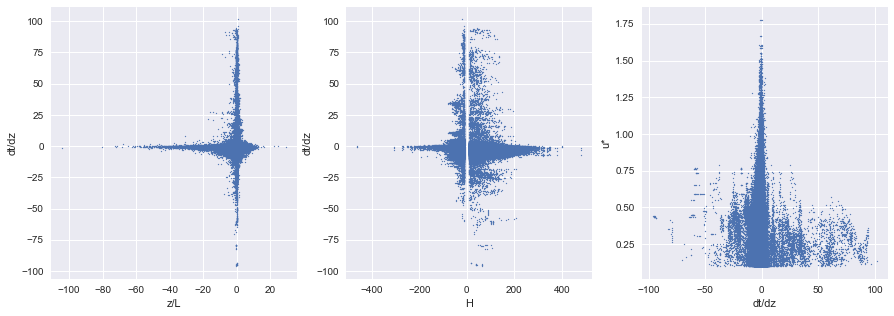

In [202]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df.zL, df.dtdz, s=1)
plt.xlabel('z/L'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 2)
plt.scatter(df.H, df.dtdz, s=1)
plt.xlabel('H'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 3)
plt.scatter(df.dtdz, df.ustar, s=1)
plt.xlabel('dt/dz'); plt.ylabel('u*')
plt.show()